# Data Analytics Project - Models

# Pair 2 - BEML Linear Regression Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from regressors import stats

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 2 Orders Dataset

## 2.1. Get the orders

In [3]:
orders_df = pd.read_csv('../../Preprocess/Pair2/Pair2_orders.csv')
orders_df.head()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
0,2018-08-06,909.099976,880.049988,29.049988,1.821236,SHORT
1,2018-08-07,868.599976,873.700012,-5.100037,0.672698,FLAT
2,2018-08-08,825.150024,876.500000,-51.349976,-0.882785,GET_OUT_OF_POSITION
3,2018-08-09,810.150024,878.750000,-68.599976,-1.462939,FLAT
4,2018-08-10,807.750000,865.250000,-57.500000,-1.089624,FLAT


In [4]:
orders_df.tail()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
54,2018-10-29,561.150024,591.450012,-30.299988,-0.174830,FLAT
55,2018-10-30,585.650024,603.950012,-18.299988,0.228756,FLAT
56,2018-10-31,587.250000,627.000000,-39.750000,-0.492654,FLAT
57,2018-11-01,632.400024,674.450012,-42.049988,-0.570007,FLAT
58,2018-11-02,688.900024,676.000000,12.900024,1.278078,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

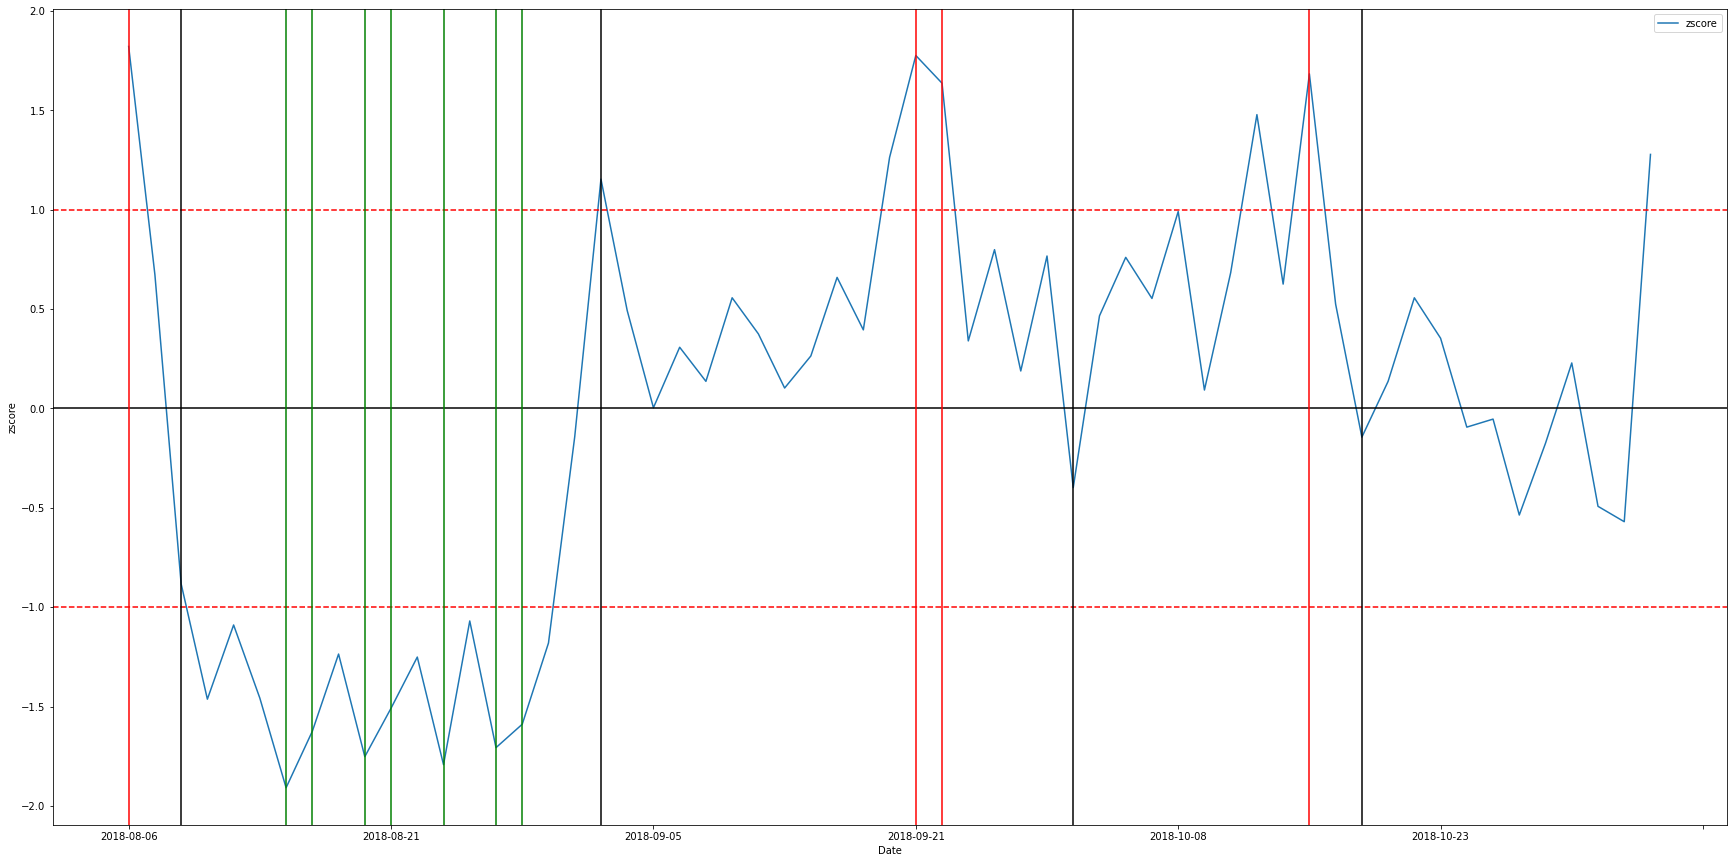

In [5]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

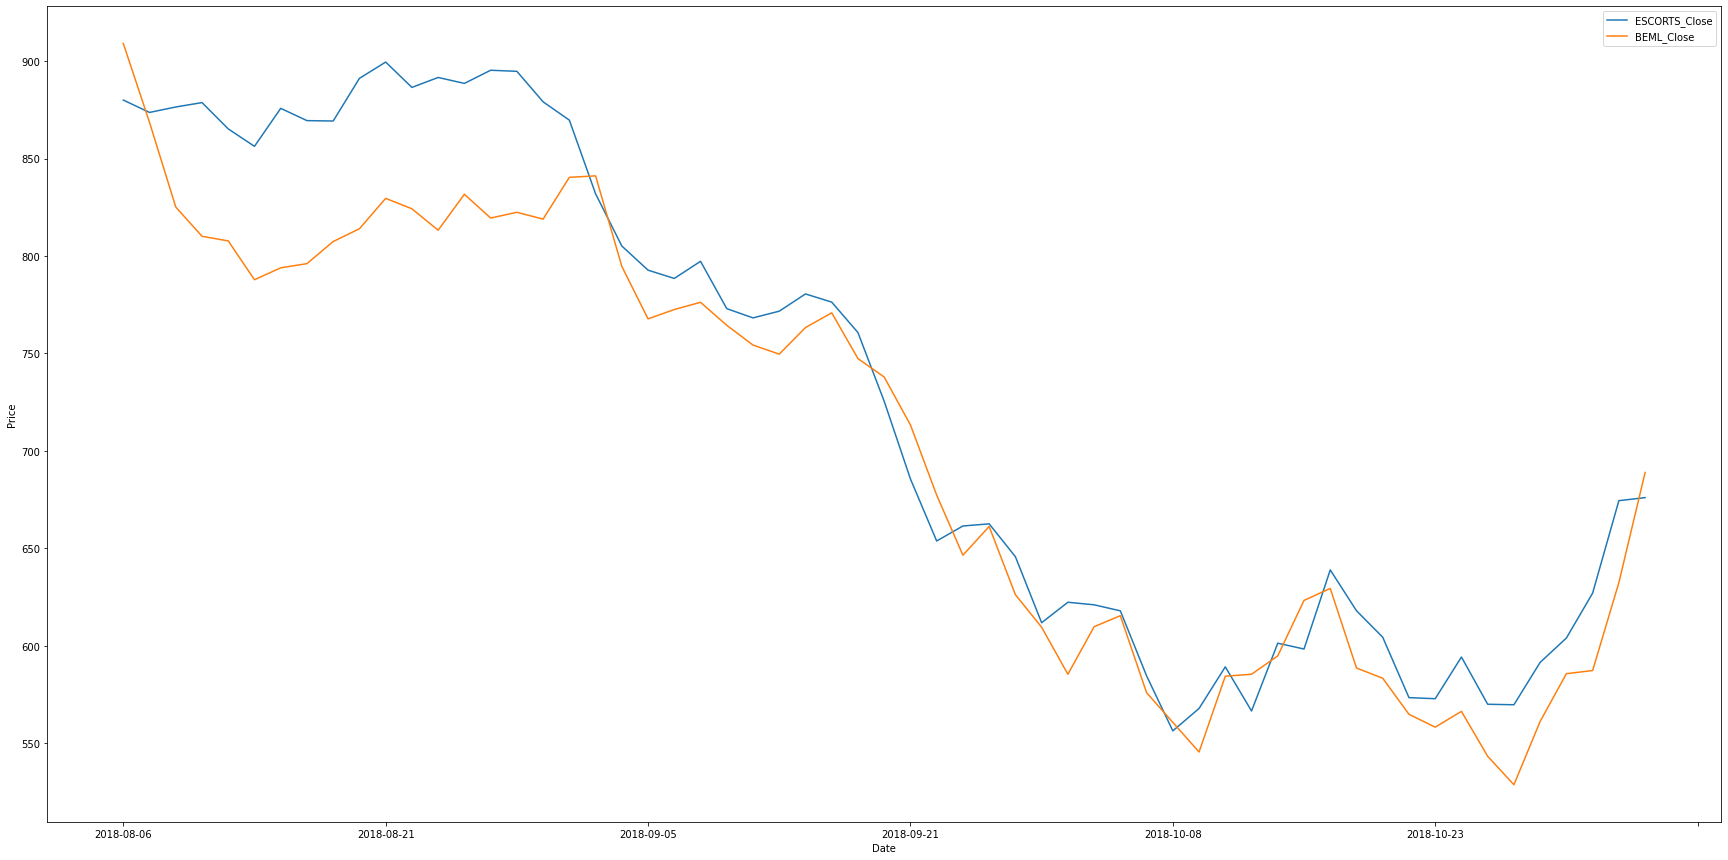

In [6]:
orders_df_plt = orders_df.plot(x='Date', y=['ESCORTS_Close', 'BEML_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. BEML Linear Regression Model

## 3.1. Get the Complete BEML dataset

In [8]:
Beml_df = pd.read_csv("../../Storage/Companies_with_names_exchange/BEMLNSE.csv")
Beml_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,1006.500000,989.150024,1004.000000,996.299988,150354.0,968.879944,BEML,NSE
1,2017-01-03,1015.950012,996.200012,1002.799988,1009.299988,285489.0,981.522095,BEML,NSE
2,2017-01-04,1023.000000,1002.750000,1013.799988,1005.799988,202005.0,978.118469,BEML,NSE
3,2017-01-05,1017.500000,993.599976,1006.400024,1001.599976,150463.0,974.033997,BEML,NSE
4,2017-01-06,1009.000000,987.900024,998.500000,993.549988,161214.0,966.205627,BEML,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get BEML training data

### 3.2.1 Get complete Beml dataset

In [9]:
Beml_df = Beml_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
Beml_df.head()

,Date,Close
0,2017-01-02,996.299988
1,2017-01-03,1009.299988
2,2017-01-04,1005.799988
3,2017-01-05,1001.599976
4,2017-01-06,993.549988


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [10]:
Beml_df_train = Beml_df[Beml_df['Date'] >= '2017-09-03']
Beml_df_train.head()

,Date,Close
166,2017-09-04,1855.599976
167,2017-09-05,1851.000000
168,2017-09-06,1836.150024
169,2017-09-07,1882.949951
170,2017-09-08,1855.949951


In [11]:
Beml_df_train = Beml_df_train[Beml_df_train['Date'] <= '2018-09-04']
Beml_df_train.tail()

,Date,Close
412,2018-08-29,822.450012
413,2018-08-30,818.950012
414,2018-08-31,840.400024
415,2018-09-03,841.150024
416,2018-09-04,794.700012


### 3.2.3 Add extra date columns to the training data

In [12]:
add_datepart(Beml_df_train, 'Date')

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
166,1855.599976,2017,36,9,4,0,247,False,False,False,False,False,False,1504483200
167,1851.000000,2017,36,9,5,1,248,False,False,False,False,False,False,1504569600
168,1836.150024,2017,36,9,6,2,249,False,False,False,False,False,False,1504656000
169,1882.949951,2017,36,9,7,3,250,False,False,False,False,False,False,1504742400
170,1855.949951,2017,36,9,8,4,251,False,False,False,False,False,False,1504828800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,822.450012,2018,35,8,29,2,241,False,False,False,False,False,False,1535500800
413,818.950012,2018,35,8,30,3,242,False,False,False,False,False,False,1535587200
414,840.400024,2018,35,8,31,4,243,True,False,False,False,False,False,1535673600
415,841.150024,2018,36,9,3,0,246,False,False,False,False,False,False,1535932800


### 3.2.4 Get the training data and labels

In [13]:
Beml_train_X = Beml_df_train.copy()

In [14]:
Beml_train_X = Beml_train_X.reset_index(drop=True)
Beml_train_X_plot = Beml_train_X.copy()
Beml_train_X = Beml_train_X.drop(columns=["Elapsed", "Close"])
Beml_train_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2017,36,9,4,0,247,False,False,False,False,False,False
1,2017,36,9,5,1,248,False,False,False,False,False,False
2,2017,36,9,6,2,249,False,False,False,False,False,False
3,2017,36,9,7,3,250,False,False,False,False,False,False
4,2017,36,9,8,4,251,False,False,False,False,False,False


In [15]:
Beml_train_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
246,2018,35,8,29,2,241,False,False,False,False,False,False
247,2018,35,8,30,3,242,False,False,False,False,False,False
248,2018,35,8,31,4,243,True,False,False,False,False,False
249,2018,36,9,3,0,246,False,False,False,False,False,False
250,2018,36,9,4,1,247,False,False,False,False,False,False


In [16]:
Beml_train_y = Beml_df[(Beml_df['Date'] >= '2017-09-04') & (Beml_df['Date'] <= '2018-09-04')]['Close']
Beml_train_y

166    1855.599976
167    1851.000000
168    1836.150024
169    1882.949951
170    1855.949951
          ...     
412     822.450012
413     818.950012
414     840.400024
415     841.150024
416     794.700012
Name: Close, Length: 251, dtype: float64

In [17]:
len(Beml_train_X)

251

In [18]:
len(Beml_train_y)

251

## 3.3. Get BEML Test Data

In [19]:
Beml_test_df = orders_df.copy()
Beml_test_df = Beml_df[(Beml_df['Date'] >= '2018-09-04') & (Beml_df['Date'] <= '2018-12-03')].copy()
Beml_test_df.head()

,Date,Close
416,2018-09-04,794.700012
417,2018-09-05,767.750000
418,2018-09-06,772.549988
419,2018-09-07,776.250000
420,2018-09-10,764.450012


In [20]:
Beml_test_df.tail()

,Date,Close
470,2018-11-27,758.849976
471,2018-11-28,775.200012
472,2018-11-29,764.950012
473,2018-11-30,752.849976
474,2018-12-03,747.599976


In [21]:
add_datepart(Beml_test_df, 'Date')
Beml_test_df.head()

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
416,794.700012,2018,36,9,4,1,247,False,False,False,False,False,False,1536019200
417,767.750000,2018,36,9,5,2,248,False,False,False,False,False,False,1536105600
418,772.549988,2018,36,9,6,3,249,False,False,False,False,False,False,1536192000
419,776.250000,2018,36,9,7,4,250,False,False,False,False,False,False,1536278400
420,764.450012,2018,37,9,10,0,253,False,False,False,False,False,False,1536537600


In [22]:
Beml_test_X = Beml_test_df.copy()
Beml_test_X = Beml_test_X.drop(columns=['Close', "Elapsed"])
Beml_test_X.reset_index(drop=True, inplace=True)
Beml_test_X.index += 251
Beml_test_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
251,2018,36,9,4,1,247,False,False,False,False,False,False
252,2018,36,9,5,2,248,False,False,False,False,False,False
253,2018,36,9,6,3,249,False,False,False,False,False,False
254,2018,36,9,7,4,250,False,False,False,False,False,False
255,2018,37,9,10,0,253,False,False,False,False,False,False


In [23]:
Beml_test_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
305,2018,48,11,27,1,331,False,False,False,False,False,False
306,2018,48,11,28,2,332,False,False,False,False,False,False
307,2018,48,11,29,3,333,False,False,False,False,False,False
308,2018,48,11,30,4,334,True,False,False,False,False,False
309,2018,49,12,3,0,337,False,False,False,False,False,False


In [24]:
Beml_test_y = Beml_df[(Beml_df['Date'] >= '2018-09-04') & (Beml_df['Date'] <= '2018-12-03')]
Beml_test_y.reset_index(drop=True, inplace=True)
Beml_test_y.index += 251
Beml_test_y = Beml_test_y['Close']

In [25]:
Beml_test_y

251    794.700012
252    767.750000
253    772.549988
254    776.250000
255    764.450012
256    754.299988
257    749.650024
258    763.299988
259    770.849976
260    747.349976
261    737.900024
262    713.299988
263    677.299988
264    646.450012
265    661.200012
266    626.200012
267    609.500000
268    585.349976
269    609.750000
270    615.400024
271    575.900024
272    560.650024
273    545.450012
274    584.349976
275    585.349976
276    594.799988
277    623.250000
278    629.400024
279    588.549988
280    583.299988
281    564.799988
282    558.200012
283    566.299988
284    543.250000
285    528.650024
286    561.150024
287    585.650024
288    587.250000
289    632.400024
290    688.900024
291    708.250000
292    714.400024
293    713.299988
294    729.250000
295    720.650024
296    723.250000
297    709.299988
298    725.299988
299    700.450012
300    730.299988
301    755.950012
302    749.549988
303    750.799988
304    764.650024
305    758.849976
306    775

In [26]:
len(Beml_test_X)

59

In [27]:
len(Beml_test_y)

59

## 3.4 Create and Train BEML Model

In [28]:
model = LinearRegression()
model = model.fit(Beml_train_X, Beml_train_y)

## 3.5. Get predictions

In [29]:
predictions = model.predict(Beml_test_X)
predictions_df = pd.DataFrame(predictions, columns=['predictions'])
predictions_df.index += 251
predictions_df

,predictions
251,762.413834
252,755.794835
253,749.175836
254,742.556836
255,747.687468
256,741.068469
257,734.449470
258,721.211471
259,726.342103
260,719.723104


In [30]:
predictions_df['test_data'] = Beml_test_y
predictions_df

,predictions,test_data
251,762.413834,794.700012
252,755.794835,767.750000
253,749.175836,772.549988
254,742.556836,776.250000
255,747.687468,764.450012
256,741.068469,754.299988
257,734.449470,749.650024
258,721.211471,763.299988
259,726.342103,770.849976
260,719.723104,747.349976


In [31]:
predictions = predictions_df['predictions']
predictions

251    762.413834
252    755.794835
253    749.175836
254    742.556836
255    747.687468
256    741.068469
257    734.449470
258    721.211471
259    726.342103
260    719.723104
261    713.104104
262    699.866106
263    704.996738
264    698.377738
265    691.758739
266    685.139740
267    678.520740
268    749.913919
269    656.255927
270    649.636927
271    643.017928
272    648.148560
273    641.529561
274    634.910561
275    628.291562
276    621.672563
277    626.803195
278    620.184195
279    613.565196
280    600.327197
281    605.457829
282    598.838830
283    592.219831
284    585.600831
285    578.981832
286    584.112464
287    577.493465
288    610.577434
289    630.427823
290    599.074234
291    604.204866
292    597.585867
293    590.966868
294    577.728869
295    582.859501
296    576.240502
297    569.621503
298    563.002503
299    556.383504
300    561.514136
301    554.895137
302    548.276137
303    541.657138
304    540.168771
305    533.549771
306    526

In [32]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Beml_test_y, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(Beml_test_y, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Beml_test_y, predictions)))
print('R2 Score:', metrics.r2_score(Beml_test_y, predictions))

Mean Absolute Error: 83.8190370259838
Mean Squared Error: 12561.979990210622
Root Mean Squared Error: 112.08023907099155
R2 Score: -0.9248386118771235


## 3.6. Visualize the predicitons vs test data

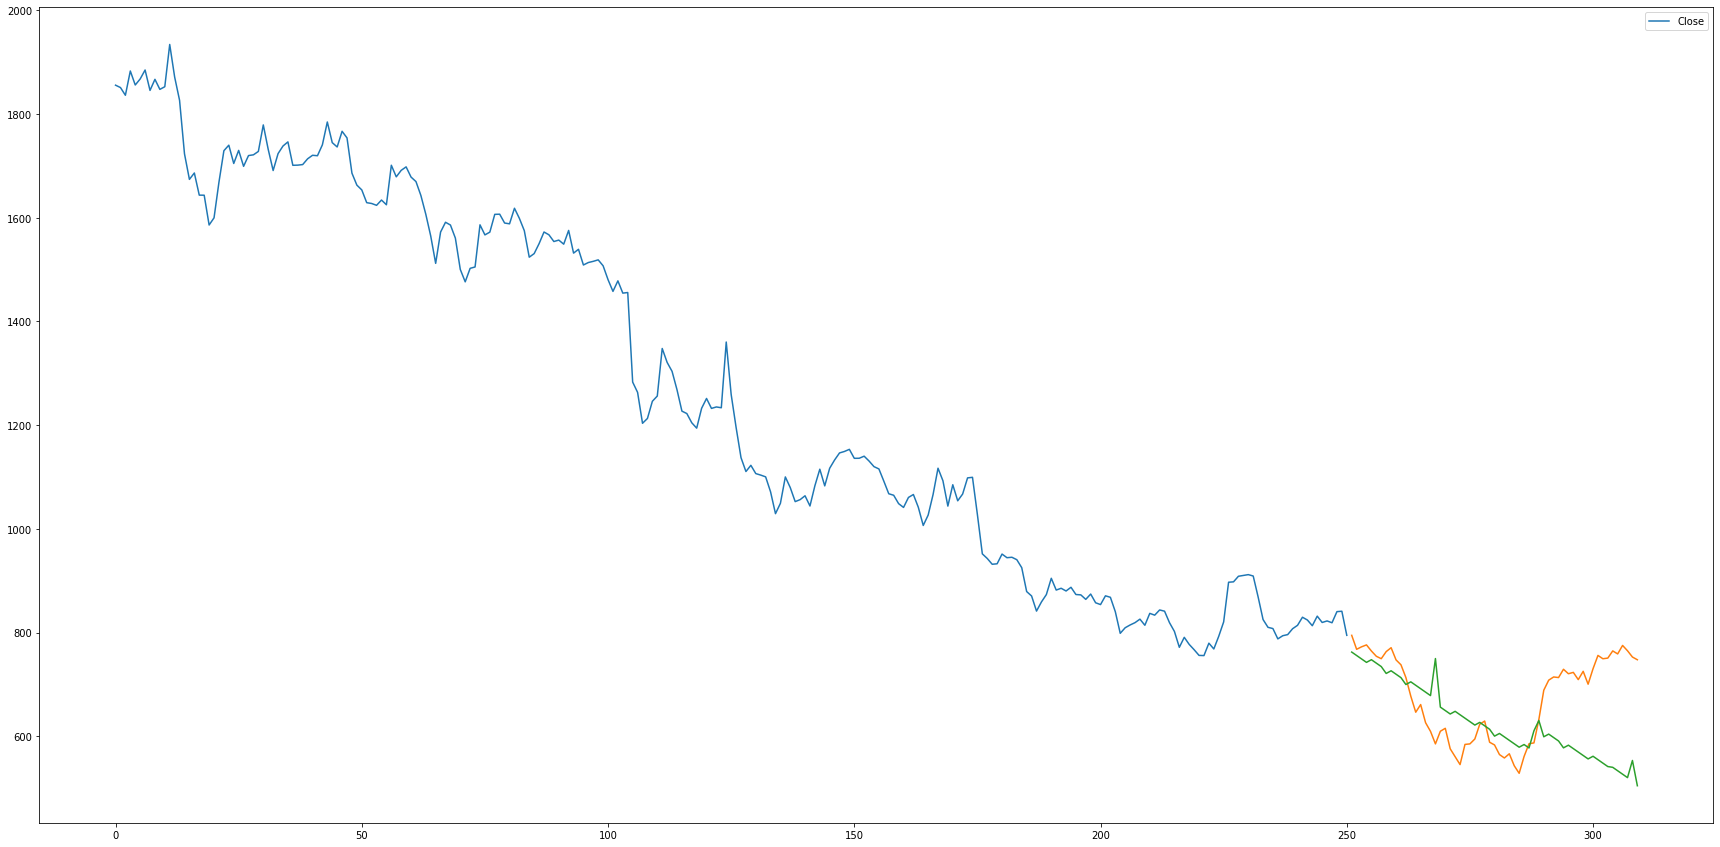

In [33]:
Beml_model_plt = Beml_train_X_plot.plot(y=['Close'], figsize=(30,15))
Beml_model_plt.plot(predictions_df['test_data'])
Beml_model_plt.plot(predictions_df['predictions'])

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results into a file

In [34]:
Beml_predictions_data = {'Date': orders_df['Date'], 'Actual_Close': orders_df['BEML_Close']}
Beml_predictions_df = pd.DataFrame(Beml_predictions_data)
Beml_predictions_df.head()

,Date,Actual_Close
0,2018-08-06,909.099976
1,2018-08-07,868.599976
2,2018-08-08,825.150024
3,2018-08-09,810.150024
4,2018-08-10,807.750000


In [35]:
predictions_df = predictions_df.reset_index()
Beml_predictions_df['Linear_regression_Close'] = predictions_df['predictions']
Beml_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2018-08-06,909.099976,762.413834
1,2018-08-07,868.599976,755.794835
2,2018-08-08,825.150024,749.175836
3,2018-08-09,810.150024,742.556836
4,2018-08-10,807.750000,747.687468


In [36]:
Beml_predictions_df.to_csv('Beml_predicitions.csv', index=False)